# Imports

In [1]:
# imports
import sys
sys.path.append('..')
from functions import *
from geometry import *
from networks import *
from plotting import *
from transforms import *
from distribution import *
import scipy.ndimage

In [2]:
import os
# Change to the directory where the train folder is located
os.chdir('../writeup_shapes')
# Verify the change
print("New Working Directory:", os.getcwd())

New Working Directory: /Users/giuliofilippi/Documents/Code/fpm-paper/writeup_shapes


In [3]:
# import matplotlib
import matplotlib.pyplot as plt

# format sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

# matplotlib params
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['xtick.direction'] = 'out' # ticks points outwards
plt.rcParams['lines.linewidth'] = 2.0 # bigger linewidth
plt.rcParams['svg.fonttype'] = 'none' # matplotlib svg text setting

In [4]:
def is_point_inside_quadrilateral(point, vertices):
    """
    Check if a point is inside a quadrilateral defined by its vertices.
    """
    A, B, C, D = vertices
    
    # Define vectors
    AB = B - A
    BC = C - B
    CD = D - C
    DA = A - D
    
    # Define cross products
    cross_AB_AP = np.cross(AB, point - A)
    cross_BC_BP = np.cross(BC, point - B)
    cross_CD_CP = np.cross(CD, point - C)
    cross_DA_DP = np.cross(DA, point - D)
    
    # Check if point is inside the quadrilateral
    return (np.dot(cross_AB_AP, cross_BC_BP) >= 0) and \
           (np.dot(cross_BC_BP, cross_CD_CP) >= 0) and \
           (np.dot(cross_CD_CP, cross_DA_DP) >= 0) and \
           (np.dot(cross_DA_DP, cross_AB_AP) >= 0)

def generate_quadrilateral_image(width, height, vertices):
    """
    Generate a black and white image with a white rectangle defined by its vertices.
    """
    image = np.zeros((height, width))
    for i in range(width):
        for j in range(height):
            if is_point_inside_quadrilateral(np.array([i, j]), vertices):
                image[height-j-1, i] = 1  # White pixel
    return image

In [5]:
def is_point_inside_triangle(point, vertices):
    """
    Check if a point is inside a triangle defined by its vertices.
    """
    A, B, C = vertices
    # Compute vectors
    v0 = C - A
    v1 = B - A
    v2 = point - A
    # Compute dot products
    dot00 = np.dot(v0, v0)
    dot01 = np.dot(v0, v1)
    dot02 = np.dot(v0, v2)
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)
    # Compute barycentric coordinates
    inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
    u = (dot11 * dot02 - dot01 * dot12) * inv_denom
    v = (dot00 * dot12 - dot01 * dot02) * inv_denom
    # Check if point is inside triangle
    return (u >= 0) and (v >= 0) and (u + v <= 1)

def generate_triangle_image(width, height, vertices):
    """
    Generate a black and white image with a white triangle defined by its vertices.
    """
    image = np.zeros((height, width))
    for i in range(width):
        for j in range(height):
            if is_point_inside_triangle(np.array([i, j]), vertices):
                image[height-j-1, i] = 1  # White pixel
    return image

In [6]:
def generate_double_triangle_image(width, height, vertices_1, vertices_2):
    """
    Generate a black and white image with a white triangle defined by its vertices.
    """
    image = np.zeros((height, width))
    for i in range(width):
        for j in range(height):
            a = is_point_inside_triangle(np.array([i, j]), vertices_1)
            b = is_point_inside_triangle(np.array([i, j]), vertices_2)
            if a or b:
                image[height-j-1, i] = 1  # White pixel
    return image

In [7]:
def plot_generated_image(im, title='Image', fpm=None, plf=None, feeder=None, sfpm=None, wfpm=None, elf=None):
    # fig size
    extent = (0, 360, 0, 90)
    plt.figure(figsize=(6.4, 6.4/2))
    plt.imshow(im, cmap='binary', extent=extent)
    plt.title(title)
    plt.xlabel('pattern width (°)')
    plt.ylabel('pattern height (°)')

    # lines
    if feeder is None:
        plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
    if fpm is not None:
        plt.axvline(x=fpm, color='green', linestyle='--', label='FPM match')
    if plf is not None:
        plt.axvline(x=plf, color='blue', linestyle='--', label='pLF match')
    if feeder is not None:
        plt.axvline(x=feeder, color='white', linestyle='-', label='Feeder')
    if elf is not None:
        plt.axvline(x=elf, color='blue', linestyle='--', label='eLF')
    if wfpm is not None:
        plt.axvline(x=wfpm, color='blue', linestyle='--', label='wFPM')
    if sfpm is not None:
        plt.axvline(x=sfpm, color='green', linestyle='--', label='sFPM')

    # Formatting
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: str(int(x))[:2]))
    ax.set_xlim(-67, 200)  # Restrict x-axis to -90 to 90
    ax.set_position([0.1, 0.1, 0.9, 0.8])
    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Define ticks from -50 to 200 in steps of 25
    ticks = np.arange(-50, 225, 25)
    ax.set_xticks(ticks)
    # Label only every other tick
    labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
    ax.set_xticklabels(labels)

# Train Image 1A

In [8]:
roll = 30
train_path = np.load('../paths/train/path_1a.npy')
train_image = train_path[0]
FPM = compute_fpm(train_image)
FPM

0.1875

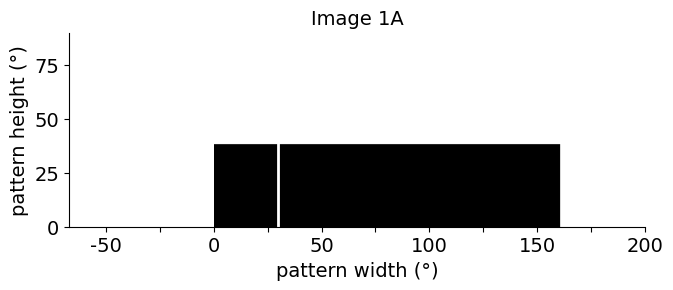

In [9]:
vertices = np.array([[180-30,0],[180-30,38],[180+130,38],[180+130,0]])+np.array([-180+30,0])
im = generate_quadrilateral_image(360*4, 90*4, vertices*4)
plot_generated_image(im, title='Image 1A', feeder=30)
# Save the plot as an SVG file
plt.savefig("shapes_sup/sup_train.svg", format="svg", bbox_inches='tight')

# Sup Test Image 1

In [10]:
0.1875*120

22.5

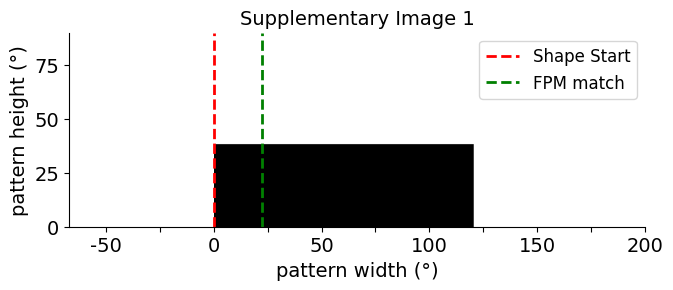

In [11]:
vertices = np.array([[180-30,0],[180-30,38],[180+90,38],[180+90,0]])+np.array([-180+30,0])
im = generate_quadrilateral_image(360*4, 90*4, vertices*4)
plot_generated_image(im, title='Supplementary Image 1', fpm= 22.5)
plt.legend()
# Save the plot as an SVG file
plt.savefig("shapes_sup/sup_test_1.svg", format="svg", bbox_inches='tight')

# Sup Test Image 2

In [12]:
0.1875*80

15.0

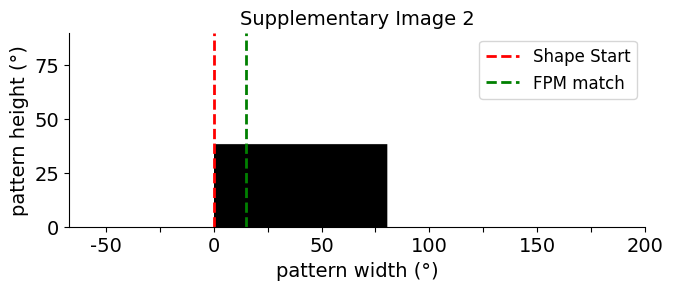

In [13]:
vertices = np.array([[180-30,0],[180-30,38],[180+50,38],[180+50,0]])+np.array([-180+30,0])
im = generate_quadrilateral_image(360*4, 90*4, vertices*4)
plot_generated_image(im, title='Supplementary Image 2', fpm= 15)
plt.legend()
# Save the plot as an SVG file
plt.savefig("shapes_sup/sup_test_2.svg", format="svg", bbox_inches='tight')

# Sup Test Image 3

In [14]:
0.1875*40

7.5

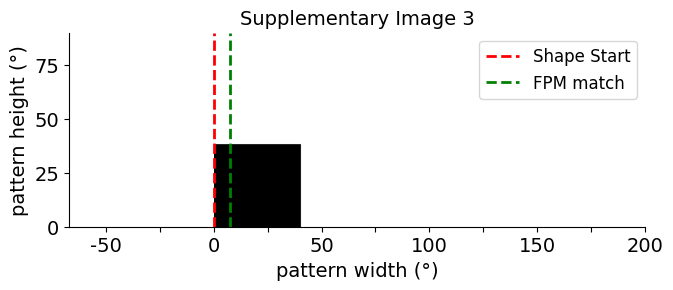

In [15]:
vertices = np.array([[180-30,0],[180-30,38],[180+10,38],[180+10,0]])+np.array([-180+30,0])
im = generate_quadrilateral_image(360*4, 90*4, vertices*4)
plot_generated_image(im, title='Supplementary Image 3', fpm= 7.5)
plt.legend()
# Save the plot as an SVG file
plt.savefig("shapes_sup/sup_test_3.svg", format="svg", bbox_inches='tight')